In [1]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (
    Input,
    Dense,
    Reshape,
    Flatten,
    Dropout,
    BatchNormalization,
    Activation,
    ZeroPadding2D,
    LeakyReLU,
    UpSampling2D,
    Conv2D,
    Convolution2D,
    MaxPooling2D,
    Concatenate,
    GaussianNoise,
    GaussianDropout,
    Lambda,
    GlobalAveragePooling2D,
)

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import to_categorical

import h5py
import pickle
import csv

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import pathlib
from pathlib import Path

import time

import math

In [2]:
print("Tensorflow version: ", tf.version.VERSION)  # tf2
print("Keras version: ", tf.keras.__version__)  # 2.2.4-tf

# tf.enable_eager_execution()  # tf2
print("Is eager execution enabled: ", tf.executing_eagerly())
print("Is there a GPU available: ", tf.config.list_physical_devices("GPU"))  # tf2

Tensorflow version:  2.1.0
Keras version:  2.2.4-tf
Is eager execution enabled:  True
Is there a GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
path_all_tfrecord = "fp56.tfrecord"

path_train_tfrecord = "fp56_train.tfrecord"
path_test_tfrecord = "fp56_test.tfrecord"

In [4]:
dir_from = "/data/fp_img_processed/"

In [5]:
dir_model = "vgg_cam/"
pathlib.Path(dir_model).mkdir(parents=True, exist_ok=True)

In [6]:
def read_mono_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    mono = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return mono

def read_bgr_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    bgr = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return bgr

def save_bgr_to_image_unicode(bgr, path, ext_to=".png"):
    """workaround for non-ascii filenames"""

    _, numpyarray = cv2.imencode(ext_to, bgr)
    with open(path, "wb") as file:
        file.write(numpyarray)

# vgg

In [7]:
fp_dim = (56, 56, 6)


def _parse_function(example_proto):
    # Create a description of the features.
    feature_description = {
        "floorplan": tf.io.FixedLenFeature(
            fp_dim, tf.float32, default_value=tf.zeros(fp_dim, tf.float32)
        ),
        "plan_id": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "year": tf.io.FixedLenFeature([], tf.int64, default_value=-1),  # 0~9
        # "sido": tf.FixedLenFeature([], tf.int64, default_value=-1),
        # "norm_area": tf.FixedLenFeature([], tf.float32, default_value=0.0),
        # "num_rooms": tf.FixedLenFeature([], tf.int64, default_value=-1),
        # "num_baths": tf.FixedLenFeature([], tf.int64, default_value=-1),
    }

    # Parse the input tf.Example proto using the dictionary above.
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    return parsed_example["floorplan"], parsed_example["year"]

In [8]:
def create_dataset(filepath):
    # This works with arrays as well
    dataset = tf.data.TFRecordDataset(filepath, compression_type="GZIP")

    # Maps the parser on every filepath in the array. You can set the number of parallel loaders here
    dataset = dataset.map(_parse_function, num_parallel_calls=4)

    ### preprocess the features

    # won't use it. use sparse_categorical_crossentropy instead of categorical_crossentropy.
    #     dataset = dataset.map(_onehot_year, num_parallel_calls=4)

    return dataset

In [9]:
def VGG16_convolutions():
    if K.image_data_format() == "channels_last":
        input_shape = (fp_dim[0], fp_dim[1], fp_dim[2])
    else:
        input_shape = (fp_dim[2], fp_dim[0], fp_dim[1])

    model = Sequential()
    model.add(
        Conv2D(
            64,
            (3, 3),
            activation="relu",
            name="conv1_1",
            padding="same",
            input_shape=input_shape,
        )
    )
    model.add(Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(1, 1), padding="same"))

    model.add(Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", name="conv2_2", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(1, 1), padding="same"))

    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_1", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_2", padding="same"))
    model.add(Conv2D(256, (3, 3), activation="relu", name="conv3_3", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_1", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_2", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv4_3", padding="same"))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_1", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_2", padding="same"))
    model.add(Conv2D(512, (3, 3), activation="relu", name="conv5_3", padding="same"))
    return model

In [10]:
num_classes = 10


def create_model():
    model = VGG16_convolutions()

    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer="sgd", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

# load

In [11]:
df = pd.read_csv("vgg_activation_top10.csv", index_col=0)
df

,5039_105,199_86,317_96,10667_66,5504_70,5814_94,2112_49_0,959_89A,2430_58
4976_62,,,,,,,,,
7963_180B,100754_163B,2888_118A,2893_118A,7963_118A,6338_162,12685_172A,2923_121,108_168,15045_109B
106355_102,2102_82,1183_199,2672_162,16429_107,8208_77,2836_121,2401_101,3896_103,6519_105
10415_106A2,23950_102,23956_102,23961_103,8289_182,10422_86,15156_129,9106_154,3376_107B,25022_77B
25507_151,104253_110D1,104253_110D,26013_109,100995_109B,25765_83B,105202_119A,13160_110C,19189_198A,26216_111C
105024_113A,105322_112C,104895_109A,104893_137B,103531_82B,105377_123,103537_114B1,104986_111F,105812_128B,103547_108A
109468_111A1,107330_82C,115505_123A,109215_123C,108144_99C,109497_87C,108805_94B,107429_130A,109395_94B,107324_109A


In [12]:
model = create_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 56, 56, 64)        3520      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       2

In [14]:
# model-12-1.23.hdf5 - loss: 1.2337 - accuracy: 0.5033 - train accuracy: 0.5749
# model-14-1.27.hdf5 - loss: 1.2704 - accuracy: 0.5168 - train accuracy: 0.6033
# model-16-1.35.hdf5 - loss: 1.3514 - accuracy: 0.5331 - train accuracy: 0.6455 #########

path_best = dir_model + "model-16-1.35.hdf5"
path_best

'vgg_cam/model-16-1.35.hdf5'

In [15]:
model.load_weights(path_best)

# class activation map

In [16]:
# Get the 512 input weights to the softmax.
class_weights = model.layers[-1].get_weights()[0]

In [17]:
class_weights.shape

(512, 10)

In [18]:
class_weights.mean(), class_weights.std()

(-0.00032434263, 0.11030664)

In [19]:
# bias for 10 of 5-year classes
model.layers[-1].get_weights()[1]

array([-0.32224256, -0.22646117, -0.20837353,  0.02055918,  0.16211072,
        0.12320401,  0.16629513,  0.05436507,  0.13303962,  0.09750742],
      dtype=float32)

In [20]:
def get_fp_output(fp, model=model):
    final_conv_layer = model.get_layer("conv5_3")
    get_output = K.function(
        [model.layers[0].input], [final_conv_layer.output, model.layers[-1].output]
    )

    conv_output, prediction = get_output(np.expand_dims(fp, 0))
    return np.squeeze(conv_output, axis=0), np.argmax(prediction)

In [21]:
def plot_bgr(img):
    fig = plt.figure(figsize=(6, 4), dpi=300)
    plt.axes().axis("off")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()

In [22]:
def plot_rgb(img):
    fig = plt.figure(figsize=(6, 4), dpi=300)
    plt.axes().axis("off")
    plt.imshow(img)
    plt.tight_layout()

In [23]:
def plot_gray(img, cmap=plt.cm.gray):
    fig = plt.figure(figsize=(6, 4), dpi=300)
    plt.axes().axis("off")
    plt.imshow(img, cmap=cmap)
    plt.tight_layout()

In [24]:
# fp_img = read_bgr_from_image_unicode('/fp_img/107323_110B.jpg')
# plot_bgr(fp_img)

In [25]:
def fp_float_from_mono(mono):
    """create 0 or 1 binary mask image from 
    wall/entrance/LDK/bedroom/balcony/bathroom stacked array"""

    # AREA_WALL = 64
    # AREA_ENTRANCE = 32
    # AREA_LDK = 16
    # AREA_BEDROOM = 8
    # AREA_BALCONY = 4
    # AREA_BATHROOM = 2

    mask_bits = np.array([64, 32, 16, 8, 4, 2], dtype=np.uint8)
    mask = np.broadcast_to(mask_bits, (*mono.shape[:2], 6))

    unit_comb = (((np.expand_dims(mono, 2) & mask) > 0)).astype(np.float32)

    return unit_comb


def pad_fp(fp, width=112, height=112):
    """place the fp at the bottom center of padded image."""
    h, w = np.subtract(fp.shape[:2], (height, width))
    if h > 0:
        fp = fp[h : h + height, :, :]
    if w > 0:
        fp = fp[:, w // 2 : w // 2 + width, :]

    h, w = np.subtract((height, width), fp.shape[:2])
    fp = np.pad(fp, ((max(h, 0), 0), (max(w // 2, 0), max(w - w // 2, 0)), (0, 0)))
    return fp

In [26]:
mono = read_mono_from_image_unicode(dir_from + "2888_118A" + ".png")
fp_full = fp_float_from_mono(mono)
fp = pad_fp(fp_full, 56, 56)

conv_output, prediction = get_fp_output(fp)

In [27]:
fp_full.shape

(62, 60, 6)

In [28]:
conv_output.shape, prediction.shape

((14, 14, 512), ())

In [29]:
prediction

4

In [30]:
def get_fp_cam(fp, model=model):
    class_weights = model.layers[-1].get_weights()[0]

    conv_output, prediction = get_fp_output(fp, model)
    true_class_weights = class_weights[:, prediction]

    cam = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for i, w in enumerate(true_class_weights):
        cam += w * conv_output[:, :, i]
    return cam

In [31]:
cam = get_fp_cam(fp)
cam = cv2.resize(cam, (56, 56))
cam /= cam.max()
cam[cam <= 0] = 0

In [32]:
cam.shape

(56, 56)

In [33]:
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)
heatmap[cam < 0.2] = 0

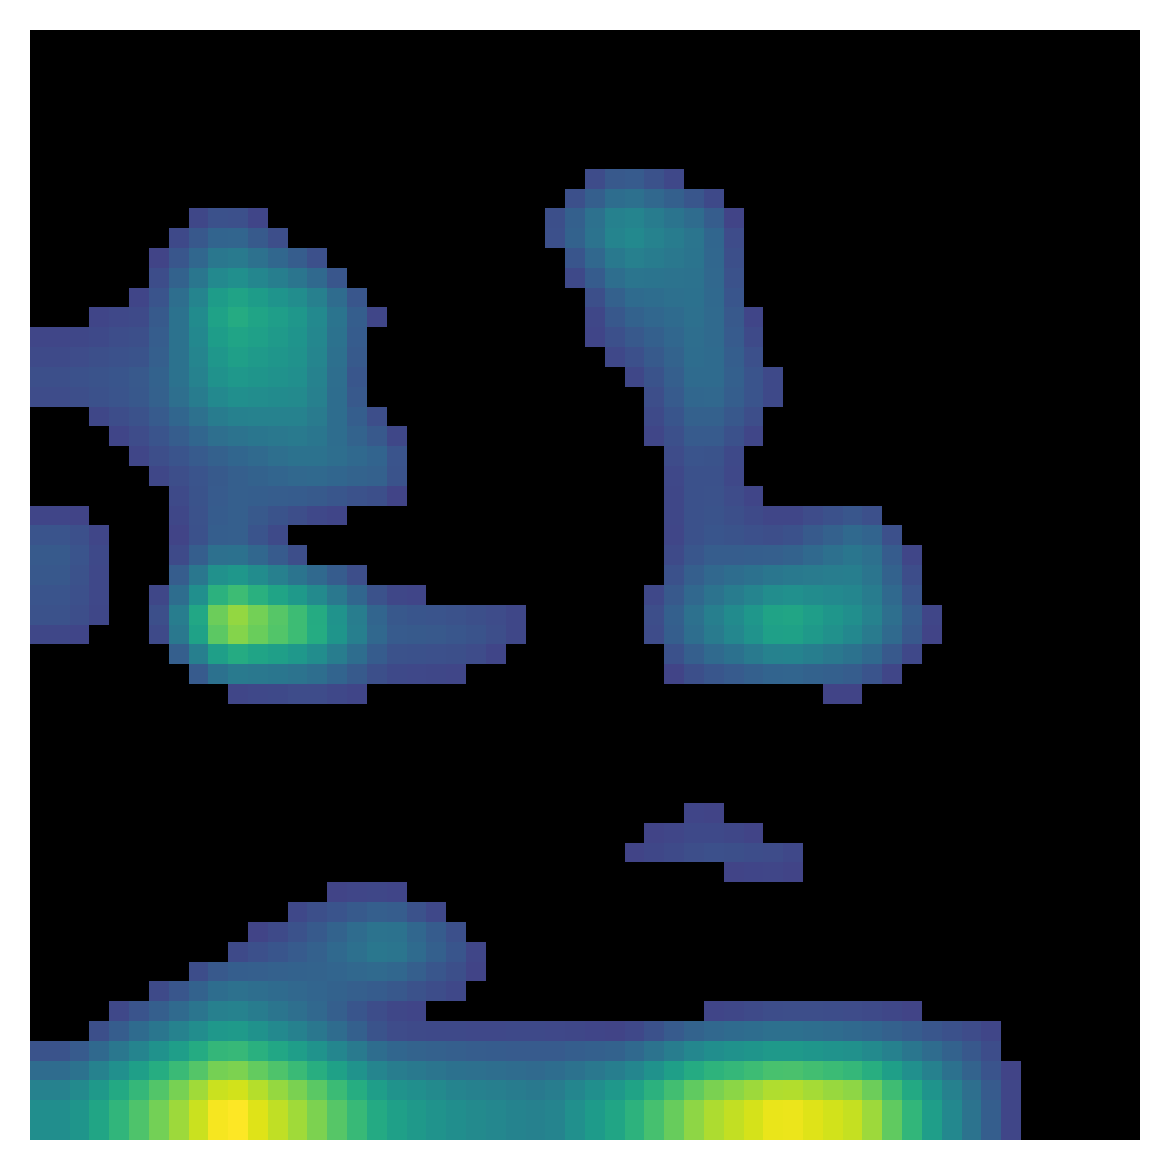

In [34]:
plot_bgr(heatmap)

In [35]:
def visualize_fp(fps):
    # adjusted for different luminance
    channel_to_rgba = np.array(
        [
            [0.0, 0.0, 0.0, 0.0],  # wall to black L0
            [0.0, 0.33, 0.0, 0.0],  # entrance to green L30
            [1.0, 0.25, 0.0, 0.0],  # LDK to red L57
            [0.83, 0.87, 0.0, 0.0],  # bedroom to yellow L85
            [0.0, 0.26, 1.0, 0.0],  # balcony to blue L40
            [0.0, 0.81, 0.76, 0.0],  # bathroom to cyan L75
        ]
    )

    # make colors subtractive
    channel_to_rgba[:, 0:3] -= 1

    # put it on white
    fps_rgba = np.clip(
        np.array([1.0, 1.0, 1.0, 1.0]) + (np.array(fps) @ channel_to_rgba), 0, 1
    )
    return fps_rgba.astype(np.float32)

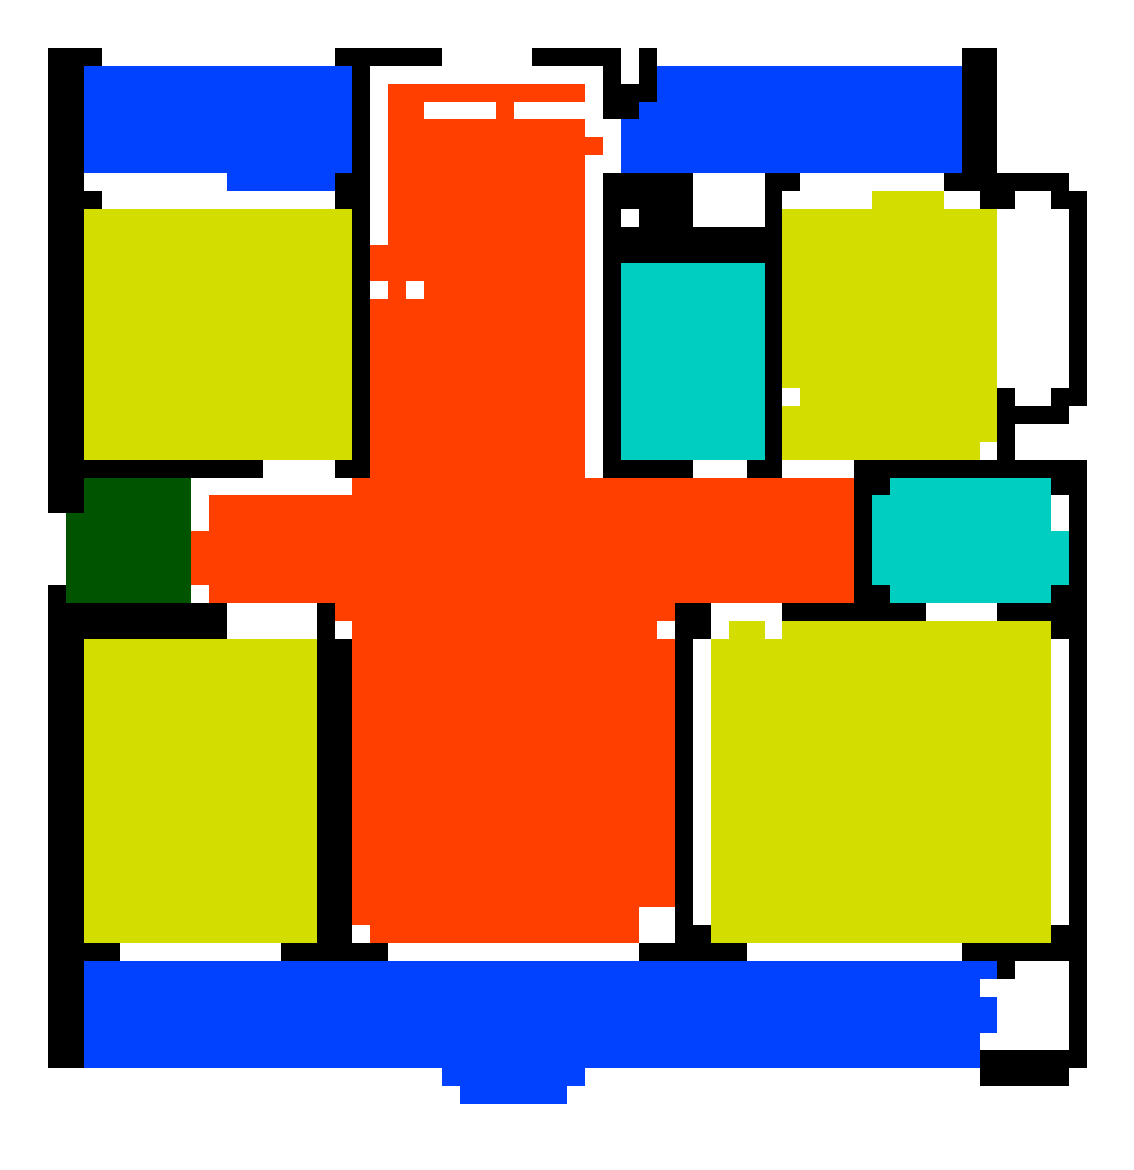

In [36]:
rgba = visualize_fp(fp_full)
plot_rgb(rgba)

In [37]:
def visualize_fp_cam(fp):
    fp_rgba = visualize_fp(fp)
    fp_light = cv2.cvtColor(fp_rgba, cv2.COLOR_RGB2Lab)[:, :, 0] / 100
    
    fp_pad = pad_fp(fp, 56, 56)
    
    cam = get_fp_cam(fp_pad)
    cam = cv2.resize(cam, (56, 56))
    cam /= cam.max()
    cam[cam <= 0] = 0

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_VIRIDIS)
    heatmap[cam < 0.2] = 0
    heatmap = pad_fp(heatmap, fp_light.shape[1], fp_light.shape[0])
    heatmap = heatmap.astype(np.float32) / 255

    return 0.7 * heatmap + 0.3 * np.expand_dims(fp_light, 2)

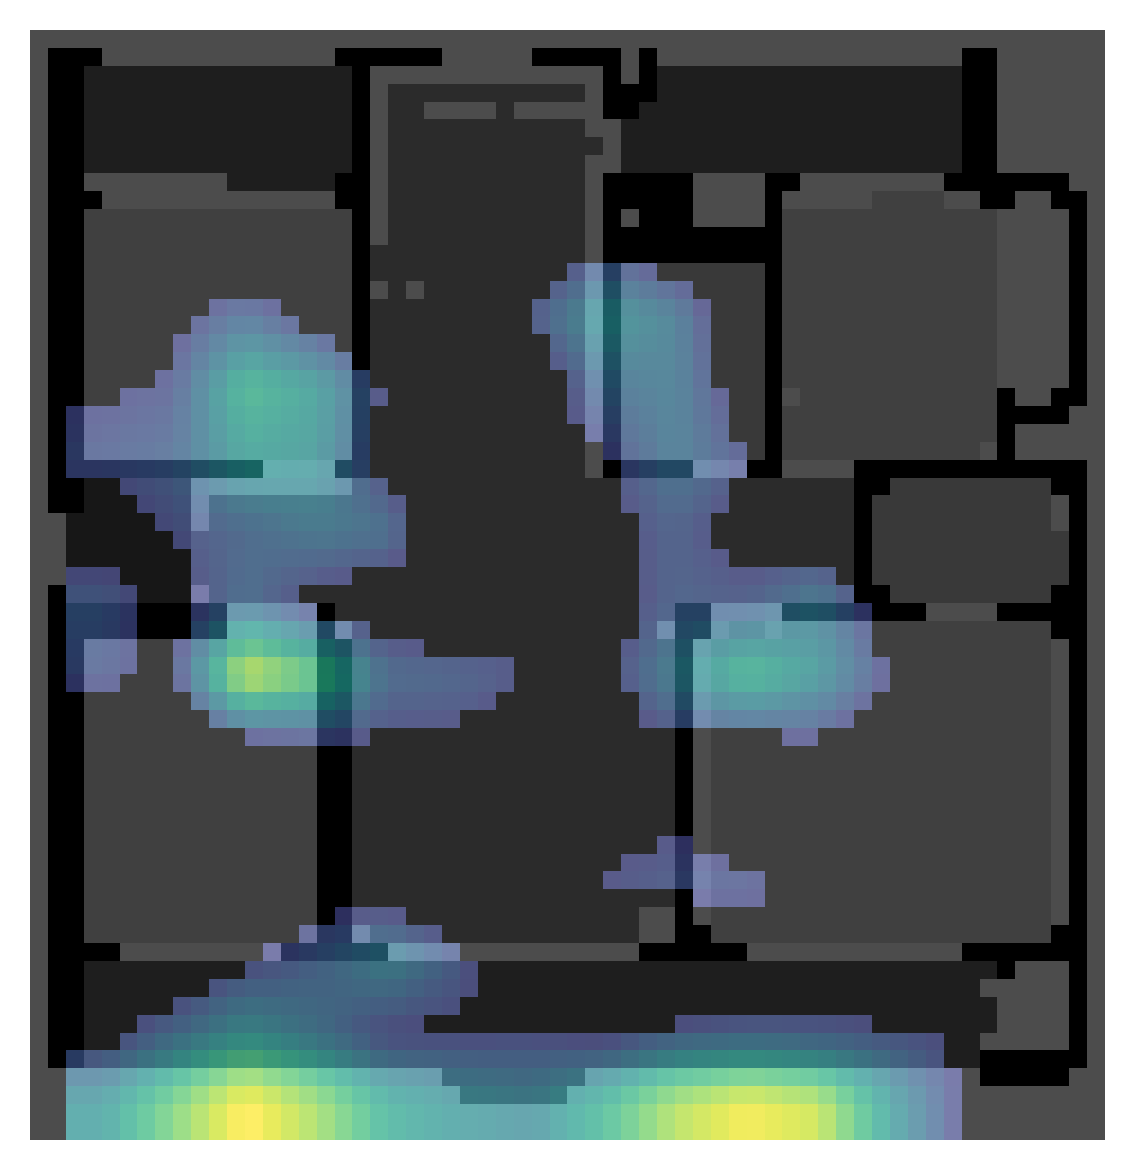

In [38]:
plot_bgr(visualize_fp_cam(fp_full))

# process top floorplans

In [39]:
def read_from_csv(filepath, columns=False):
    if Path(filepath).is_file():

        with open(filepath, "r", newline="", encoding="utf-8-sig") as csvfile:
            listreader = csv.reader(csvfile)
            if columns:
                columns = next(listreader)
            readlist = list(listreader)

    else:
        columns = []
        readlist = []

    if columns:
        return columns, readlist
    else:
        return readlist


def write_to_csv(lines, filepath, columns=None):
    Path(filepath).parent.mkdir(parents=True, exist_ok=True)

    with open(filepath, "w", newline="", encoding="utf-8-sig") as csvfile:
        listwriter = csv.writer(csvfile)

        if columns is not None:
            listwriter.writerow(columns)

        for line in lines:
            listwriter.writerow(line)

In [40]:
top_ids = read_from_csv("vgg_activation_top10.csv")
top_ids

[[],
 [],
 [],
 ['4976_62',
  '5039_105',
  '199_86',
  '317_96',
  '10667_66',
  '5504_70',
  '5814_94',
  '2112_49_0',
  '959_89A',
  '2430_58'],
 ['7963_180B',
  '100754_163B',
  '2888_118A',
  '2893_118A',
  '7963_118A',
  '6338_162',
  '12685_172A',
  '2923_121',
  '108_168',
  '15045_109B'],
 ['106355_102',
  '2102_82',
  '1183_199',
  '2672_162',
  '16429_107',
  '8208_77',
  '2836_121',
  '2401_101',
  '3896_103',
  '6519_105'],
 ['10415_106A2',
  '23950_102',
  '23956_102',
  '23961_103',
  '8289_182',
  '10422_86',
  '15156_129',
  '9106_154',
  '3376_107B',
  '25022_77B'],
 ['25507_151',
  '104253_110D1',
  '104253_110D',
  '26013_109',
  '100995_109B',
  '25765_83B',
  '105202_119A',
  '13160_110C',
  '19189_198A',
  '26216_111C'],
 ['105024_113A',
  '105322_112C',
  '104895_109A',
  '104893_137B',
  '103531_82B',
  '105377_123',
  '103537_114B1',
  '104986_111F',
  '105812_128B',
  '103547_108A'],
 ['109468_111A1',
  '107330_82C',
  '115505_123A',
  '109215_123C',
  '10814

In [41]:
dir_vis = dir_model + "visualization/"
pathlib.Path(dir_vis).mkdir(parents=True, exist_ok=True)

for year, top_list in enumerate(top_ids):
    for i, fp_id in enumerate(top_list):
        save_bgr_to_image_unicode(cv2.resize(
            visualize_fp_cam(
                fp_float_from_mono(
                    read_mono_from_image_unicode(dir_from + fp_id + ".png")
                )
            ), None, fx=16, fy=16, interpolation=cv2.INTER_NEAREST)*255,
            dir_vis + f"{1970+5*year}_{i}_{fp_id}.png",
        )

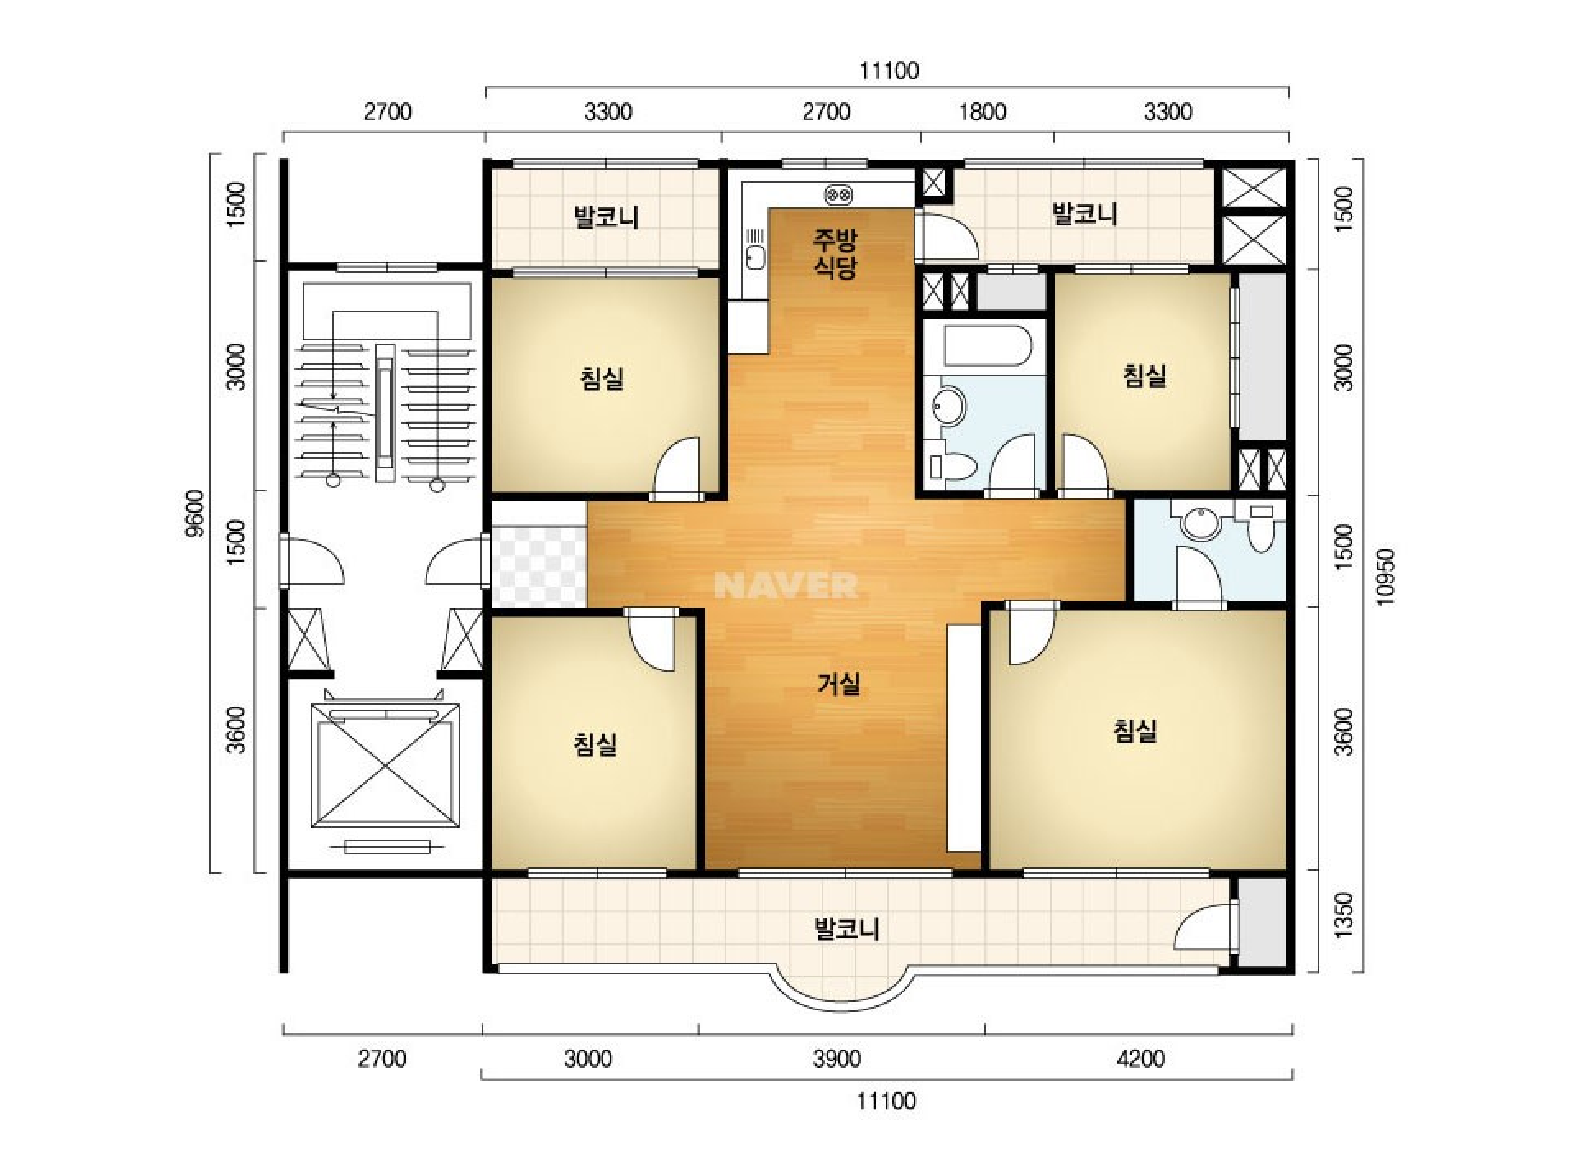

In [24]:
ID = '2888_118A'
plot_bgr(read_bgr_from_image_unicode(f'/fp_img/{ID}.jpg'))